# SSD

In [1]:
import chainer
import numpy as np
import os
import pickle

## 訓練データ

PASCAL VOC2007から作成した小さいデータセット  
・人間か犬が写っている画像200枚と、その対象のラベルと位置

In [2]:
from chainercv.chainer_experimental.datasets.sliceable import GetterDataset
from chainercv.utils import read_image

label_names = ('person', 'dog')

class VOCBboxDataset(GetterDataset):
    # データセット
    def __init__(self, use_difficult=False):
        super(VOCBboxDataset, self).__init__()

        self.data_dir = 'data/detection_data/'
        path = os.path.join(self.data_dir, 'detection_data.pkl')
        with open(path, 'rb') as f:
            self.dic = pickle.load(f)

        self.add_getter('img', self._get_image)
        self.add_getter(('bbox', 'label'), self._get_annotations)
        
        self.keys = ('img', 'bbox', 'label')

    def __len__(self):
        return len(self.dic)

    def _get_image(self, i):
        id_ = self.dic[i]['id']
        img_path = os.path.join(self.data_dir, 'JPEGImages', id_ + '.jpg')
        img = read_image(img_path, color=True)
        return img

    def _get_annotations(self, i):
        bbox, label = self.dic[i]['bbox'], self.dic[i]['label']
        return bbox, label

In [3]:
import copy
from chainercv import transforms
from PIL import Image

class Transform(object):
    # 画像や物体の位置を適する形に変換
    def __init__(self, coder, size, mean):
        self.coder = copy.copy(coder)

        self.size = size  # networkへ入力する画像サイズ
        self.mean = mean  # 画像の平均強度

    def __call__(self, in_data):
        img, bbox, label = in_data

        # 画像のリサイズとそれに伴う位置の修正
        _, H, W = img.shape
        img = np.transpose(img, (1, 2, 0))
        img = Image.fromarray(np.uint8(img))
        img = img.resize((self.size, self.size))
        img = np.asarray(img, dtype=np.float32)
        img = np.transpose(img, (2, 0, 1))
        bbox = transforms.resize_bbox(bbox, (H, W), (self.size, self.size))

        # Preparation
        img -= self.mean
        loc, label = self.coder.encode(bbox, label)

        return img, loc, label

## モデル

サイズの小さいSSD

SSDの前半の層はimagenetで学習済みのVGG16を使用する。

In [4]:
from chainer import functions as F
from chainer import initializers
from chainer import links as L
from chainercv.links.model.ssd.ssd_vgg16 import VGG16
from chainercv.links.model.ssd import SSD
from chainercv import utils
from chainercv.links.model.ssd import Multibox

_imagenet_mean = np.array((123, 117, 104)).reshape((-1, 1, 1))

class VGG16Extractor150(VGG16):
    # 複数のスケールの特徴を抽出する部分
    # VGG16はchainercvのクラス
    # それに追加で層を加える
    insize = 150
    grids = (19, 10, 5)

    def __init__(self):
        init = {
            'initialW': initializers.LeCunUniform(),
            'initial_bias': initializers.Zero(),
        }
        super(VGG16Extractor150, self).__init__()
        with self.init_scope():
            self.conv8_1 = L.Convolution2D(256, 1, **init)
            self.conv8_2 = L.Convolution2D(512, 3, stride=2, pad=1, **init)

    def __call__(self, x):
        ys = super(VGG16Extractor150, self).__call__(x)
        for i in range(8, 9):
            h = ys[-1]
            h = F.relu(self['conv{:d}_1'.format(i)](h))
            h = F.relu(self['conv{:d}_2'.format(i)](h))
            ys.append(h)
        return ys
    
    
class SSD150(SSD):
    # SSD全体
    
    _models = {
        'imagenet': {
            'url': 'https://chainercv-models.preferred.jp/'
            'ssd_vgg16_imagenet_converted_2017_06_09.npz',
            'cv2': True
        },
    }

    def __init__(self, n_fg_class=None, pretrained_model=None):
        param, path = utils.prepare_pretrained_model(
            {'n_fg_class': n_fg_class}, pretrained_model, self._models)

        super(SSD150, self).__init__(
            extractor=VGG16Extractor150(),
            multibox=Multibox(
                n_class=param['n_fg_class'] + 1,
                aspect_ratios=((2,), (2, 3), (2, 3))),
            steps=(16, 32, 64),
            sizes=(60, 111, 162, 213),
            mean=_imagenet_mean)
        
        if path:
            chainer.serializers.load_npz(path, self, strict=False)

In [5]:
model = SSD150(
        n_fg_class=2,
        pretrained_model='imagenet')

/Users/sasakiwataru/anaconda3/lib/python3.6/site-packages/chainercv/utils/link.py:60: RuntimeWarning: cv2 is not installed on your environment. Pretrained models are trained with cv2. The performace may change with Pillow backend.
  RuntimeWarning)


In [6]:
from chainer.datasets import TransformDataset
# データセットを作成
train = TransformDataset(
    VOCBboxDataset(),
    Transform(model.coder, model.insize, model.mean))
train_iter = chainer.iterators.SerialIterator(train, batch_size=5)

In [7]:
from chainercv.links.model.ssd import multibox_loss

class MultiboxTrainChain(chainer.Chain):
    # SSDの出力と教師データを受け取ってSSDの損失関数を計算する部分
    def __init__(self, model, alpha=1, k=3):
        super(MultiboxTrainChain, self).__init__()
        with self.init_scope():
            self.model = model
        self.alpha = alpha
        self.k = k

    def __call__(self, imgs, gt_mb_locs, gt_mb_labels):
        mb_locs, mb_confs = self.model(imgs)
        loc_loss, conf_loss = multibox_loss(
            mb_locs, mb_confs, gt_mb_locs, gt_mb_labels, self.k)
        loss = loc_loss * self.alpha + conf_loss

        chainer.reporter.report(
            {'loss': loss, 'loss/loc': loc_loss, 'loss/conf': conf_loss},
            self)

        return loss

In [8]:
train_chain = MultiboxTrainChain(model)

## 学習

In [9]:
from chainercv.links.model.ssd import GradientScaling
from chainer.optimizer_hooks import WeightDecay
# 最適化手法はモメンタムSGD
optimizer = chainer.optimizers.MomentumSGD(lr=1e-4)
optimizer.setup(train_chain)
# 正則化
for param in train_chain.params():
    if param.name == 'b':
        param.update_rule.add_hook(GradientScaling(2))
    else:
        param.update_rule.add_hook(WeightDecay(0.0005))

In [10]:
from chainer import training
from chainer.training import extensions

# trainer設定
updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=-1)
trainer = training.Trainer(updater, stop_trigger=(100, 'iteration'), out='result')
# 出力設定
trainer.extend(extensions.LogReport(trigger=(10, 'iteration')))
trainer.extend(extensions.PrintReport(
    ['epoch', 'iteration', 'main/loss', 'main/loss/loc', 'main/loss/conf']),
    trigger=(10, 'iteration'))

In [11]:
# 実行
trainer.run()

epoch       iteration   main/loss   main/loss/loc  main/loss/conf
0           10          12.424      3.78959        8.63442         
0           20          9.2035      3.28106        5.92244         
0           30          8.97584     3.64136        5.33448         
1           40          8.28556     3.57451        4.71105         
1           50          7.50045     3.52596        3.97449         
1           60          6.89589     3.14832        3.74758         
1           70          6.34872     2.84162        3.5071          
2           80          6.48181     2.91678        3.56503         
2           90          5.87129     2.68357        3.18772         
2           100         5.80828     2.72788        3.0804          


## 結果の可視化

簡単のため訓練データに対して実際に学習できているか確認する。
（精度の検証などをするときは検証データやテストデータを別途用意して検証する）

/Users/sasakiwataru/anaconda3/lib/python3.6/site-packages/chainercv/transforms/image/resize.py:33: RuntimeWarning: cv2 is not installed on your environment. ChainerCV will fall back on Pillow. Installation of cv2 is recommended for faster computation. 
  RuntimeWarning)


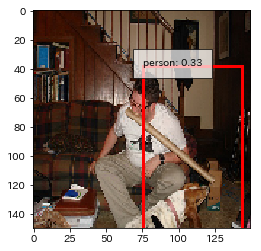

In [18]:
from chainercv.visualizations import vis_bbox
import matplotlib.pyplot as plt
% matplotlib inline

# 検出を採用するしきい値
model.nms_thresh = 0.3
model.score_thresh = 0.3

sample = train_iter.next()[0]
img, loc, label = sample
chainer.config.train=False
bboxes, labels, scores = model.predict([img])
bbox, label, score = bboxes[0], labels[0], scores[0]

vis_bbox(img+_imagenet_mean, bbox, label, score, label_names=label_names)